# CIFAR-10 Classification with MLP and CNN

This notebook demonstrates a complete workflow for classifying CIFAR-10 images with a simple MLP and a lightweight CNN. The steps are:
1. **Import data**
2. **Preprocess data** 
3. **Create models**
4. **Train & evaluate models**
5. **Plot / visualise results** (per-class accuracy histograms & learning curves)

# Step 1 ── import libraries & device setup

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


# Step 2 ── data preprocessing (no DataLoader creation here)

In [ ]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_data = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
val_data   = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

CIFAR10_CLASS_NAMES = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# make a tiny loader that just gives us a handful of examples

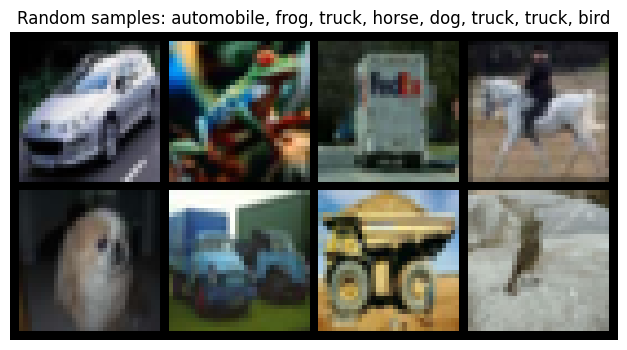

In [ ]:

sample_loader = DataLoader(train_data, batch_size=8, shuffle=True)

images, labels = next(iter(sample_loader))

# Un-normalise  (our transform brought images to [-1,1]; bring them back to [0,1])
images = images * 0.5 + 0.5

# Build a grid and plot
grid = utils.make_grid(images, nrow=4)
plt.figure(figsize=(8,4))
plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
plt.title('Random samples: ' + ', '.join([CIFAR10_CLASS_NAMES[int(l)] for l in labels]))
plt.axis('off')
plt.show()

# Step 3 ── models & utilities

In [ ]:

class MLP(nn.Module):
    """Simple 3-layer Multi-Layer Perceptron for CIFAR-10 (image flattened)."""
    def __init__(self, input_size: int = 3*32*32, num_classes: int = 10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, 1024), nn.ReLU(inplace=True),
            nn.Linear(1024, 512),   nn.ReLU(inplace=True),
            nn.Linear(512, num_classes),
        )
    def forward(self, x):
        return self.net(x)


class SimpleCNN(nn.Module):
    """Lightweight CNN with three convolutional blocks."""
    def __init__(self, num_classes: int = 10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2), nn.Dropout(0.2),  # 32×16×16
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2), nn.Dropout(0.2),  # 64×8×8
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2), # 128×4×4
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*4*4, 128), nn.ReLU(inplace=True),
            nn.Linear(128, num_classes),
        )
    def forward(self, x):
        return self.classifier(self.features(x))


def evaluate_dataset(model: nn.Module, dataset, batch_size: int = 128, *, plot_hist: bool=False, save_path: str|None=None):
    """Evaluate on a dataset (creates its own DataLoader). Optionally plots per-class accuracy."""
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    criterion = nn.CrossEntropyLoss()
    model.eval()
    correct = total = 0
    class_correct, class_total = [0]*10, [0]*10
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)
            for i, lbl in enumerate(labels):
                class_total[lbl.item()] += 1
                if preds[i].item() == lbl.item():
                    class_correct[lbl.item()] += 1
    acc = correct / total
    avg_loss = running_loss / total
    print(f'Eval — loss: {avg_loss:.4f}, acc: {acc*100:.2f}%')
    if plot_hist:
        per_class = [class_correct[i]/class_total[i] if class_total[i] else 0 for i in range(10)]
        plt.figure(figsize=(10,4))
        plt.bar(range(10), per_class, color='skyblue')
        plt.xticks(range(10), CIFAR10_CLASS_NAMES, rotation=45)
        plt.ylabel('Accuracy')
        plt.title('Per-class accuracy')
        plt.tight_layout()
        if save_path: plt.savefig(save_path)
        plt.show()
    return acc, avg_loss
def plot_confusion_matrix(model: nn.Module, dataset, class_names: list, batch_size: int = 128, *, title: str = 'Confusion Matrix', save_path: str | None = None):
    """
    Computes and plots the confusion matrix for a given model and dataset.

    Args:
        model (nn.Module): The trained model to evaluate.
        dataset: The dataset to evaluate on (e.g., val_data).
        class_names (list): A list of strings representing the names of the classes.
        batch_size (int): Batch size for the DataLoader.
        title (str): The title for the plot.
        save_path (str | None): Optional path to save the plot image.
    """
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    model.eval()  # Set the model to evaluation mode

    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculations
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Normalize the confusion matrix to show percentages if desired, or use raw counts
    # cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    # If you want to show normalized values (percentages):
    # sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', 
    #             xticklabels=class_names, yticklabels=class_names)
    
    plt.title(title)
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
    plt.show()


def train_model_dataset(model, train_set, val_set, *, epochs:int=25, batch_size:int=128, lr:float=1e-3):
    """Train on `train_set` (DataLoader created internally). Returns learning curves."""
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_set,   batch_size=batch_size, shuffle=False)
    criterion = nn.CrossEntropyLoss()
    optimiser = optim.Adam(model.parameters(), lr=lr)
    best_val_acc = 0
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    for epoch in range(1, epochs+1):
        model.train()
        run_loss = correct = total = 0
        for imgs, lbls in train_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            optimiser.zero_grad()
            outs = model(imgs)
            loss = criterion(outs, lbls)
            loss.backward()
            optimiser.step()
            run_loss += loss.item() * imgs.size(0)
            _, pr = outs.max(1)
            correct += pr.eq(lbls).sum().item()
            total += lbls.size(0)
        train_loss = run_loss / total
        train_acc  = correct / total
        # validation each epoch
        val_acc, val_loss = evaluate_dataset(model, val_set, batch_size=batch_size)
        train_losses.append(train_loss); val_losses.append(val_loss)
        val_accs.append(val_acc); train_accs.append(train_acc)
        best_val_acc = max(best_val_acc, val_acc)
        print(f'Epoch {epoch:2d}/{epochs} — train loss: {train_loss:.4f}, train acc: {train_acc*100:5.2f}% | val acc: {val_acc*100:5.2f}%')
    print(f'Best validation accuracy: {best_val_acc*100:.2f}%')
    return train_losses, val_losses, val_accs, train_accs

# Step 4 ── training & evaluation (MLP)

Eval — loss: 1.4690, acc: 48.66%
Epoch  1/10 — train loss: 1.6323, train acc: 41.96% | val acc: 48.66%
Eval — loss: 1.4079, acc: 50.89%
Epoch  2/10 — train loss: 1.4132, train acc: 50.01% | val acc: 50.89%
Eval — loss: 1.3902, acc: 51.73%
Epoch  3/10 — train loss: 1.2993, train acc: 53.81% | val acc: 51.73%
Eval — loss: 1.3671, acc: 52.37%
Epoch  4/10 — train loss: 1.1921, train acc: 57.61% | val acc: 52.37%
Eval — loss: 1.3640, acc: 53.05%
Epoch  5/10 — train loss: 1.1028, train acc: 60.93% | val acc: 53.05%
Eval — loss: 1.4029, acc: 53.07%
Epoch  6/10 — train loss: 1.0154, train acc: 63.95% | val acc: 53.07%
Eval — loss: 1.4008, acc: 53.59%
Epoch  7/10 — train loss: 0.9293, train acc: 66.98% | val acc: 53.59%
Eval — loss: 1.4651, acc: 54.40%
Epoch  8/10 — train loss: 0.8395, train acc: 70.10% | val acc: 54.40%
Eval — loss: 1.5727, acc: 53.82%
Epoch  9/10 — train loss: 0.7517, train acc: 73.37% | val acc: 53.82%
Eval — loss: 1.6510, acc: 53.70%
Epoch 10/10 — train loss: 0.6819, train 

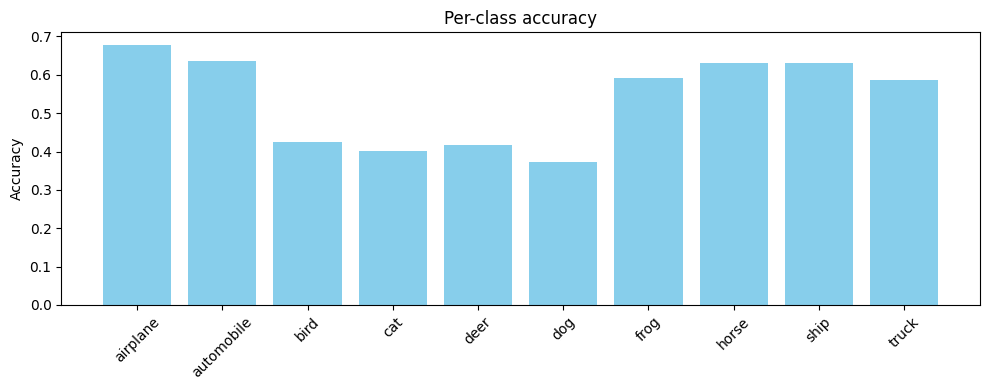

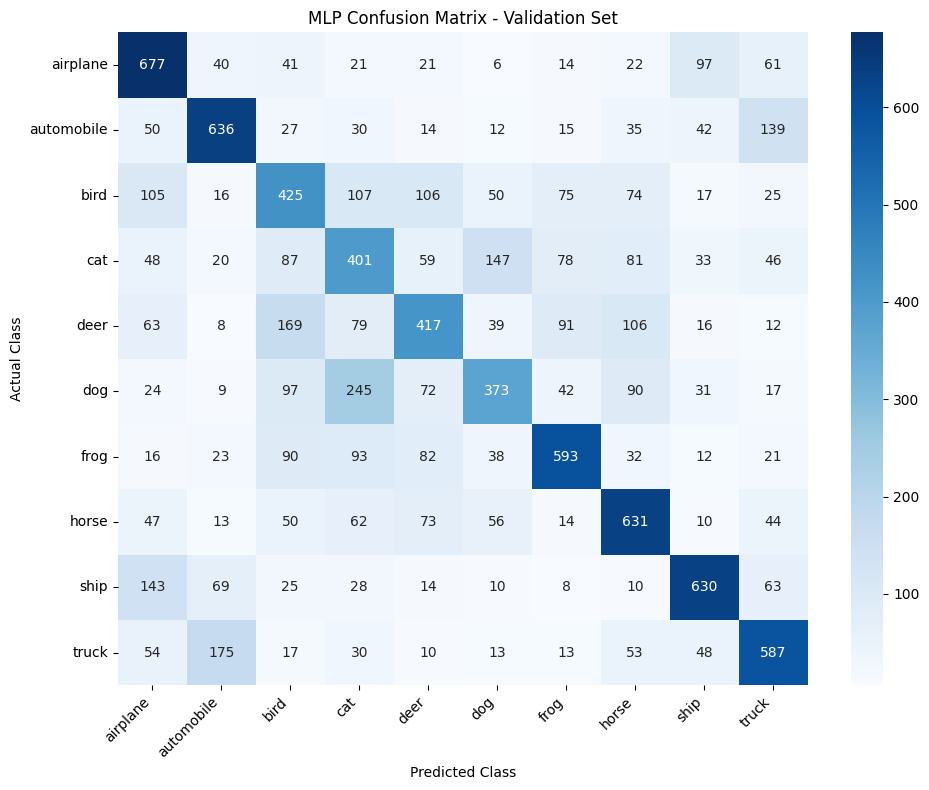

In [5]:


batch_size = 128
mlp = MLP().to(device)
mlp_train_losses, mlp_val_losses, mlp_val_accs, mlp_train_accs = train_model_dataset(mlp, train_data, val_data, epochs=10, batch_size=batch_size)
evaluate_dataset(mlp, val_data, batch_size=batch_size, plot_hist=True, save_path='mlp_hist.png')
plot_confusion_matrix(mlp, val_data, CIFAR10_CLASS_NAMES, 
                      title='MLP Confusion Matrix - Validation Set', 
                      save_path='mlp_confusion_matrix.png')

# Training & evaluation (CNN)

Eval — loss: 1.0952, acc: 61.98%
Epoch  1/10 — train loss: 1.3450, train acc: 51.52% | val acc: 61.98%
Eval — loss: 0.9625, acc: 66.07%
Epoch  2/10 — train loss: 0.9497, train acc: 66.51% | val acc: 66.07%
Eval — loss: 0.8053, acc: 72.26%
Epoch  3/10 — train loss: 0.8269, train acc: 70.87% | val acc: 72.26%
Eval — loss: 0.7389, acc: 74.49%
Epoch  4/10 — train loss: 0.7442, train acc: 73.97% | val acc: 74.49%
Eval — loss: 0.6949, acc: 75.85%
Epoch  5/10 — train loss: 0.6871, train acc: 75.99% | val acc: 75.85%
Eval — loss: 0.6572, acc: 76.82%
Epoch  6/10 — train loss: 0.6433, train acc: 77.43% | val acc: 76.82%
Eval — loss: 0.6749, acc: 76.72%
Epoch  7/10 — train loss: 0.6015, train acc: 79.13% | val acc: 76.72%
Eval — loss: 0.6700, acc: 77.43%
Epoch  8/10 — train loss: 0.5710, train acc: 80.05% | val acc: 77.43%
Eval — loss: 0.7392, acc: 74.91%
Epoch  9/10 — train loss: 0.5363, train acc: 81.05% | val acc: 74.91%
Eval — loss: 0.6236, acc: 78.69%
Epoch 10/10 — train loss: 0.5123, train 

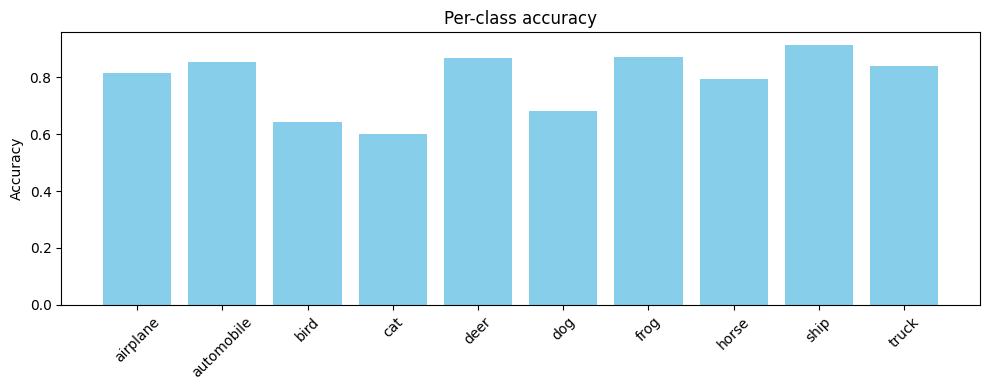

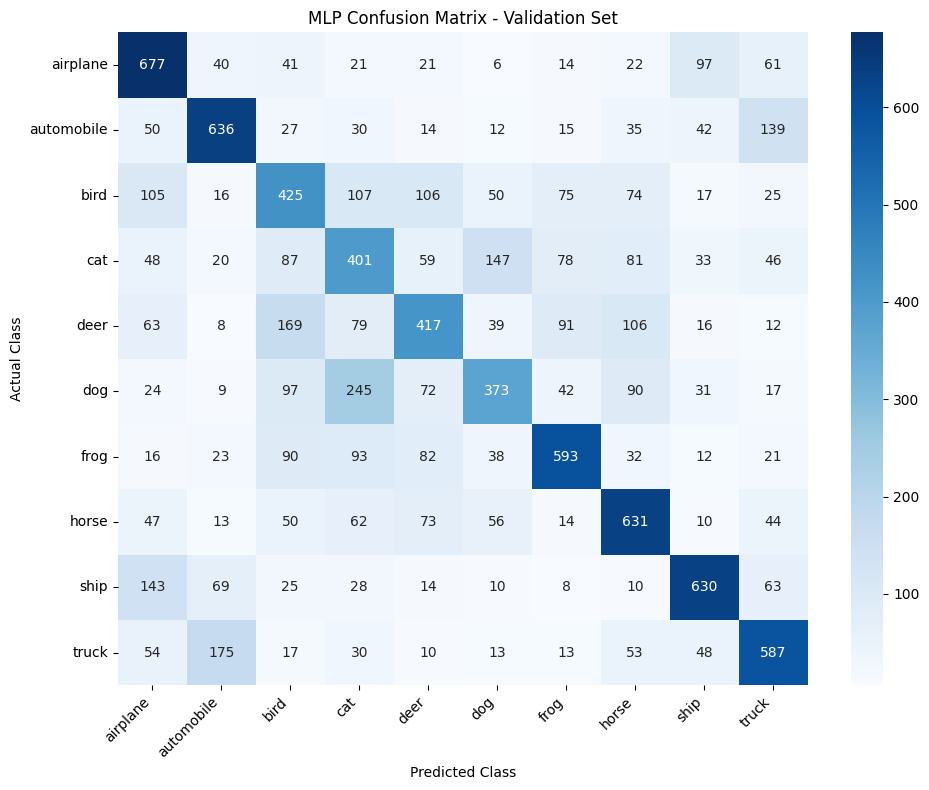

In [6]:

cnn = SimpleCNN().to(device)
cnn_train_losses, cnn_val_losses, cnn_val_accs, cnn_train_accs = train_model_dataset(
    cnn, train_data, val_data, epochs=10, batch_size=batch_size)
evaluate_dataset(cnn, val_data, batch_size=batch_size, plot_hist=True, save_path='cnn_hist.png')
plot_confusion_matrix(mlp, val_data, CIFAR10_CLASS_NAMES, 
                      title='MLP Confusion Matrix - Validation Set', 
                      save_path='mlp_confusion_matrix.png')

# Step 5 ── visualise learning curves

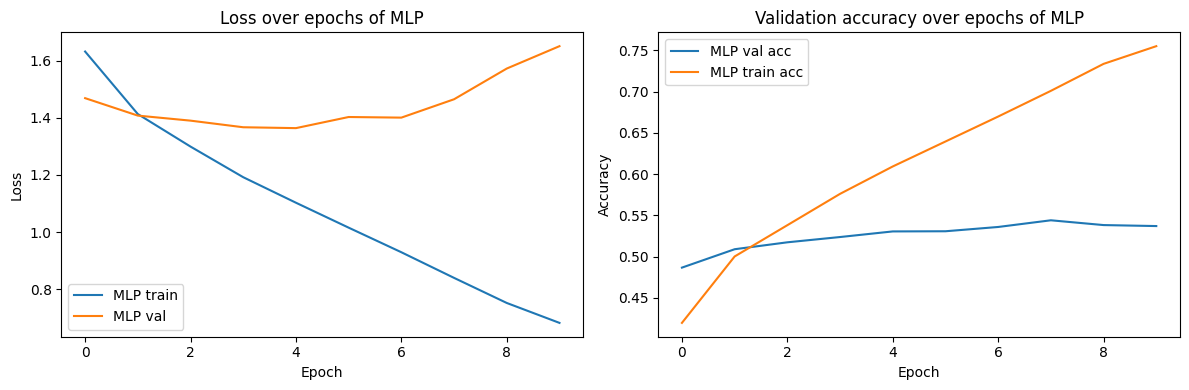

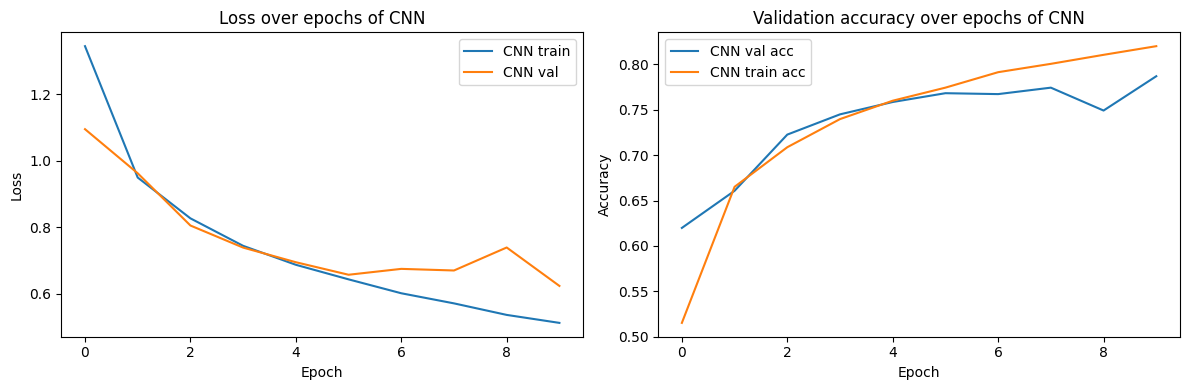

In [7]:

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(mlp_train_losses, label='MLP train')
plt.plot(mlp_val_losses, label='MLP val')
plt.title('Loss over epochs of MLP')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

plt.subplot(1,2,2)
plt.plot(mlp_val_accs, label='MLP val acc')
plt.plot(mlp_train_accs, label='MLP train acc')
plt.title('Validation accuracy over epochs of MLP')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); 
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(cnn_train_losses, label='CNN train')
plt.plot(cnn_val_losses, label='CNN val')
plt.title('Loss over epochs of CNN')
plt.xlabel('Epoch'); plt.ylabel('Loss'); 
plt.legend()

plt.subplot(1,2,2)
plt.plot(cnn_val_accs, label='CNN val acc')
plt.plot(cnn_train_accs, label='CNN train acc')
plt.title('Validation accuracy over epochs of CNN')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); 
plt.legend()
plt.tight_layout()
plt.show()
